# Курсовой проект на тему: Библиотеки Python для Data Science: Numpy, Matplotlib, Scikit-learn

Задание:
Используя данные из обучающего датасета (train.csv), построить модель для предсказания цен на недвижимость (квартиры).
С помощью полученной модели, предсказать цены для квартир из тестового датасета (test.csv).

Целевая переменная:
Price

Метрика качества:
R2 - коэффициент детерминации (sklearn.metrics.r2_score)

Требования к решению:
1. R2 > 0.6
2. Тетрадка Jupyter Notebook с кодом Вашего решения, названная по образцу {ФИО}_solution.ipynb, пример SShirkin_solution.ipynb
3. Файл CSV с прогнозами целевой переменной для тестового датасета, названный по образцу {ФИО}_predictions.csv, пример SShirkin_predictions.csv 
Файл должен содержать два поля: Id, Price и в файле должна быть 5001 строка (шапка + 5000 предсказаний).

# Обработка входных данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from scipy.stats import norm
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
#from sklearn.cluster import KMeans
#from sklearn.cluster import AgglomerativeClustering
from sklearn.ensemble import RandomForestRegressor
#from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
#from sklearn.metrics import r2_score
#from sklearn.metrics import mean_squared_error

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import warnings
warnings.filterwarnings('ignore')

Считываемм данные из набора

In [2]:
train = pd.read_csv('initial/train.csv')
test = pd.read_csv('initial/test.csv')
print("Data is loaded!")

Data is loaded!


Функции для уменьшения размера данных

In [3]:
def manual_rh_decreasetype(df):
    df['Rooms'] = df['Rooms'].astype('int64')
    df['HouseFloor'] = df['HouseFloor'].astype('int64')
    return df
def optimizing_df(df):
    for col in df.columns:
        if df[col].dtypes.kind == 'i' or df[col].dtypes.kind == 'u':
            if df[col].min() >= 0:
                df[col] = pd.to_numeric(df[col], downcast='unsigned')
            else:
                df[col] = pd.to_numeric(df[col], downcast='integer')

        elif df[col].dtypes.kind == 'f' or df[col].dtypes.kind == 'c':
            df[col] = pd.to_numeric(df[col], downcast='float')

        elif df[col].dtypes.kind == 'O':
            num_unique_values = len(df[col].unique())
            num_total_values = len(df[col])
            if num_unique_values / num_total_values < 0.5:
                df[col] = df[col].astype('category')

    return df

Проверяем качество данных

In [4]:
all_data = pd.concat((train, test), sort=False).reset_index(drop=True)
all_data.drop(['Price'], axis=1, inplace=True)
print(f'all_data size is : {all_data.shape}')

all_data size is : (15000, 19)


In [5]:
all_data.describe().transpose()

count         mean            std          min          25%  \
Id             15000.0  8393.136933    4850.111673     0.000000  4188.750000   
DistrictId     15000.0    50.693600      43.786257     0.000000    20.000000   
Rooms          15000.0     1.897000       0.839229     0.000000     1.000000   
Square         15000.0    56.360350      20.423913     1.136859    41.814371   
LifeSquare     11846.0    36.851792      71.120183     0.333490    22.896130   
KitchenSquare  15000.0     6.174467      24.016979     0.000000     1.000000   
Floor          15000.0     8.561800       5.323113     1.000000     4.000000   
HouseFloor     15000.0    12.606600       6.780165     0.000000     9.000000   
HouseYear      15000.0  3321.575067  163707.780381  1908.000000  1974.000000   
Ecology_1      15000.0     0.119196       0.119371     0.000000     0.017647   
Social_1       15000.0    24.769267      17.532278     0.000000     6.000000   
Social_2       15000.0  5370.404933    4013.364403   168.000000  1564.000000   
Social_3       15000.0     8.113667      23.841946     0.000000     0.000000   
Healthcare_1    7825.0  1144.162428    1029.296278     0.000000   350.000000   
Helthcare_2    15000.0     1.319467       1.489012     0.000000     0.000000   
Shops_1        15000.0     4.235133       4.796545     0.000000     1.000000   

                       50%           75%           max  
Id             8378.500000  12594.250000  1.679800e+04  
DistrictId       37.000000     75.000000  2.120000e+02  
Rooms             2.000000      2.000000  1.900000e+01  
Square           52.645757     66.036608  6.410652e+02  
LifeSquare       32.822810     45.144624  7.480592e+03  
KitchenSquare     6.000000      9.000000  2.014000e+03  
Floor             7.000000     12.000000  7.800000e+01  
HouseFloor       12.000000     17.000000  1.170000e+02  
HouseYear      1977.000000   2001.000000  2.005201e+07  
Ecology_1         0.075424      0.195781  5.218671e-01  
Social_1         25.000000     36.000000  7.400000e+01  
Social_2       5285.000000   7287.000000  1.908300e+04  
Social_3          2.000000      5.000000  1.410000e+02  
Healthcare_1    900.000000   1548.000000  4.849000e+03  
Helthcare_2       1.000000      2.000000  6.000000e+00  
Shops_1           3.000000      6.000000  2.300000e+01

На тестовой выборке посмотрим какие параметры наибольшим образом влияют на стоимость и определим с какого параметра начинать правку данных

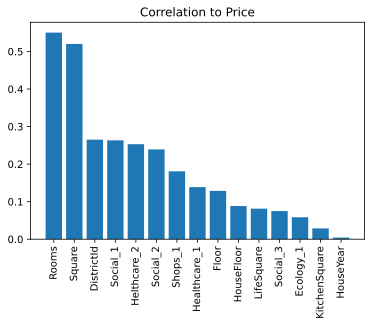

In [6]:
corrmat = train.loc[:, train.columns != 'Id'].corrwith(
    train['Price']).abs().sort_values(ascending=False)[1:]
plt.bar(corrmat.index, corrmat.values)
plt.title('Correlation to Price')
plt.xticks(rotation='vertical')
plt.show()

Начинаем править "выбивающиеся" данные.

In [7]:
#Правка количества комнат
def df_fix_room(df):
    info_by_district_id = df.groupby(['DistrictId', 'HouseYear'], as_index=False).agg(
        {'Rooms': 'sum', 'Square': 'sum'}).rename(
        columns={'Rooms': 'sum_roos_dr', 'Square': 'sum_square_dr'})

    info_by_district_id['mean_square_per_room_in_dr'] = info_by_district_id['sum_square_dr'] \
        / info_by_district_id['sum_roos_dr']
    info_by_district_id.drop(
        ['sum_square_dr', 'sum_roos_dr'], axis=1, inplace=True)

    df = pd.merge(df, info_by_district_id, on=[
                  'DistrictId', 'HouseYear'], how='left')

    df['mean_square_per_room_in_dr'] = df['mean_square_per_room_in_dr'].fillna(
        df['mean_square_per_room_in_dr'].mean())

    df.loc[df['Rooms'] > 6, 'Rooms'] \
        = (df.loc[df['Rooms'] > 6, 'Square']
           // df.loc[df['Rooms'] > 6, 'mean_square_per_room_in_dr']).astype('int')

    df.loc[df['Rooms'] == 0, 'Rooms'] \
        = (df.loc[df['Rooms'] == 0, 'Square']
           // df.loc[df['Rooms'] == 0, 'mean_square_per_room_in_dr']).astype('int')

    df.loc[df['Rooms'] == 0, 'Rooms'] = 1
    return df

In [8]:
#Правка площадей
#Если площадь больше 400, то оценив стоимости нужно поделить ее на 10.
def df_fix_square_manual(df):
    df.loc[df['Square'] > 400, 'Square'] = df.loc[df['Square'] > 400, 'Square'] / 10
    return df

#Для всех площадей
def df_fix_square(df):
    info_by_district_id = df.groupby(['DistrictId', 'Rooms', 'HouseYear'], as_index=False).agg(
        {'Square': 'mean'}).rename(
        columns={'Square': 'mean_square_rooms_dr'})

    df = pd.merge(df, info_by_district_id, on=[
        'DistrictId', 'Rooms', 'HouseYear'], how='left')

    df.loc[abs(df['Square'] - df['mean_square_rooms_dr']) > 2 * sigma, 'Square'] \
        = df.loc[abs(df['Square'] - df['mean_square_rooms_dr']) > 2 * sigma, 'Rooms'] \
        * df.loc[abs(df['Square'] - df['mean_square_rooms_dr']) > 2 * sigma, 'mean_square_per_room_in_dr']
    return df

#Правка жилого пространства
def prepare_lifesquare(df):
    df.loc[df['Square'] < df['LifeSquare'],
           'LifeSquare'] = df.loc[df['Square'] < df['LifeSquare'], 'Square']
    return df


def fillna_life_square(df):
    df['LifeSquare'] = df['LifeSquare'].fillna(df['LifeSquare'].mean())
    return df

In [9]:
#Правка года постройки
def df_fix_house_year_manual(df):
    df.loc[df['HouseYear'] == 20052011, 'HouseYear'] = int((2005 + 2011) / 2)
    df.loc[df['HouseYear'] == 4968, 'HouseYear'] = 1968
    return df

In [10]:
#Убираем лишнее
def df_del_missing(df):
    df_na = (df.isnull().sum() / len(df)) * 100

    df_na = df_na.drop(
        df_na[df_na == 0].index).sort_values(ascending=False)
    df_na = list(df_na.index)
    df.drop(df_na, axis=1, inplace=True)
    return df

# Визуализация данных

<AxesSubplot:>

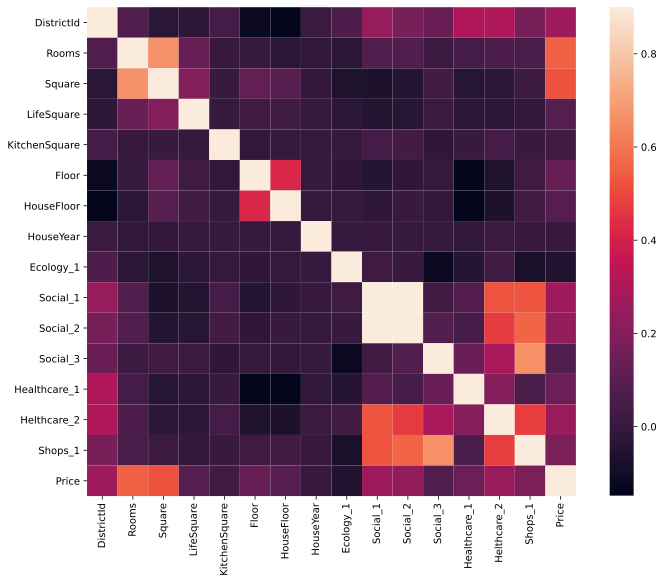

In [11]:
#Рассмотрим взаимное влияние факторов друг на друга
corrmat = train.loc[:, train.columns != 'Id'].corr()
plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=0.9, square=True)

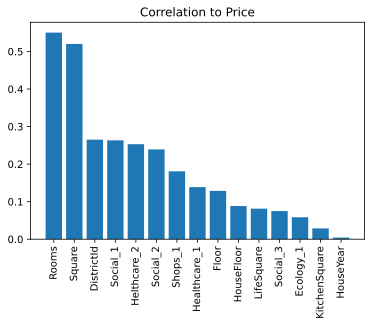

In [12]:
corrmat = train.loc[:, train.columns != 'Id'].corrwith(
    train['Price']).abs().sort_values(ascending=False)[1:]
plt.bar(corrmat.index, corrmat.values)
plt.title('Correlation to Price')
plt.xticks(rotation='vertical')
plt.show()

mu = 56.36 and sigma = 20.42


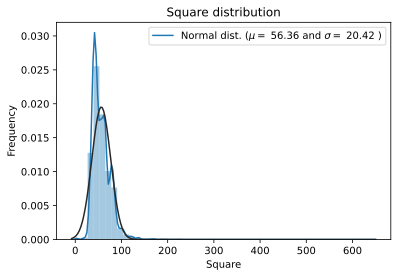

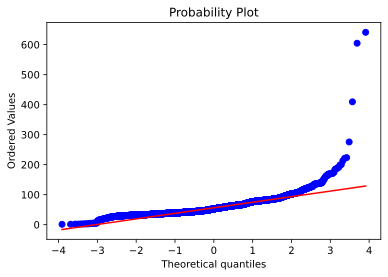

In [13]:
#Построим распределение площадей объектов

sns.distplot(all_data['Square'], fit=norm)

mu, sigma = norm.fit(all_data['Square'])

print(f'mu = {mu:.2f} and sigma = {sigma:.2f}')

plt.legend(
    [f'Normal dist. ($\mu=$ {mu:.2f} and $\sigma=$ {sigma:.2f} )'])
plt.ylabel('Frequency')
plt.title('Square distribution')

# QQ-plot
fig = plt.figure()
res = stats.probplot(all_data['Square'], plot=plt)
plt.show()

mu = 214138.86 and sigma = 92867.65


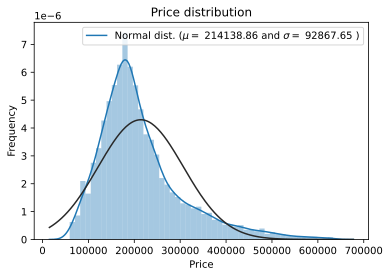

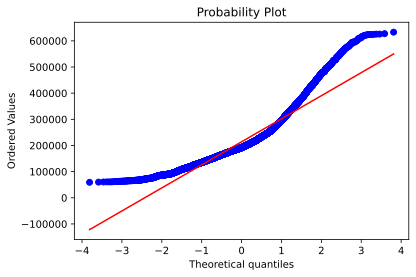

In [14]:
#Построим нормальное распределение целевой переменной
sns.distplot(train['Price'], fit=norm)

mu, sigma = norm.fit(train['Price'])

print(f'mu = {mu:.2f} and sigma = {sigma:.2f}')

plt.legend(
    [f'Normal dist. ($\mu=$ {mu:.2f} and $\sigma=$ {sigma:.2f} )'], loc='best')
plt.ylabel('Frequency')
plt.title('Price distribution')

# QQ-plot
fig = plt.figure()
res = stats.probplot(train['Price'], plot=plt)
plt.show()

mu = 214138.86 and sigma = 92867.65


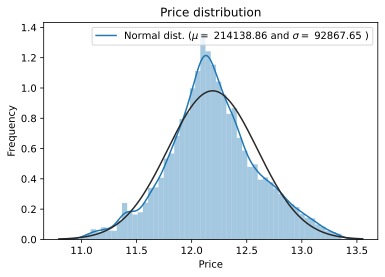

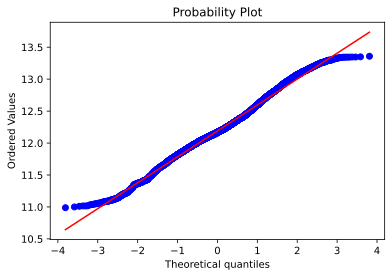

In [15]:
#Построим логнормальное распределение целевой переменной
price_log = np.log1p(train['Price'])

sns.distplot(price_log, fit=norm)

mu, sigma = norm.fit(train['Price'])

print(f'mu = {mu:.2f} and sigma = {sigma:.2f}')

plt.legend(
    [f'Normal dist. ($\mu=$ {mu:.2f} and $\sigma=$ {sigma:.2f} )'], loc='best')
plt.ylabel('Frequency')
plt.title('Price distribution')

# QQ-plot
fig = plt.figure()
res = stats.probplot(price_log, plot=plt)
plt.show()

Text(0.5, 1.0, 'Distribution of variable House Year')

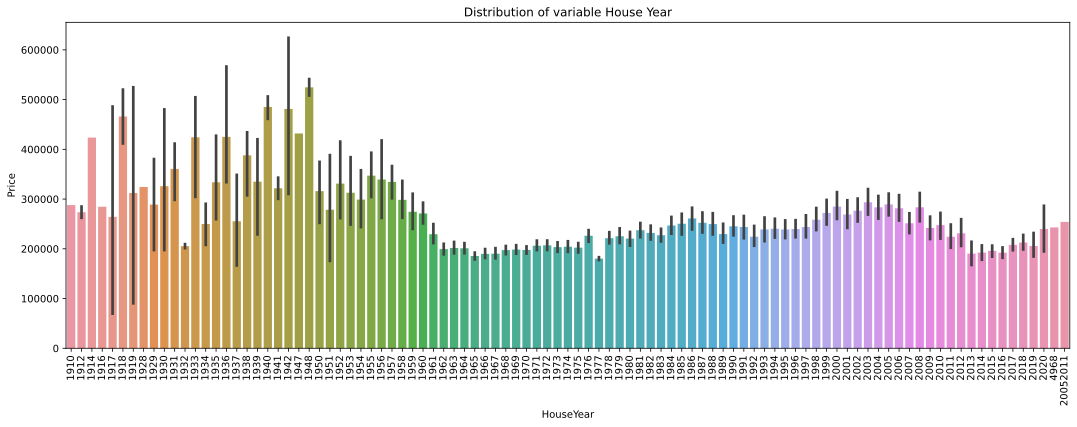

In [16]:
#Оценим влияние года постройки на стоимость
plt.figure(figsize=(18, 6))
sns.barplot(train['HouseYear'], train['Price'])
plt.xticks(rotation=90)
plt.title('Distribution of variable House Year')

Text(0.5, 1.0, 'Distribution of variable DistrictId')

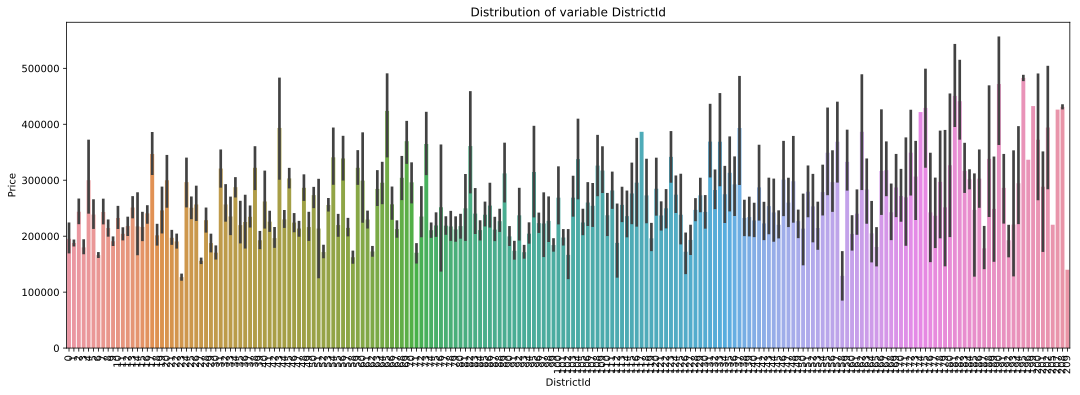

In [17]:
#Оценим влияние района постройки на стоимость
plt.figure(figsize=(18, 6))
sns.barplot(train['DistrictId'], train['Price'])
plt.xticks(rotation=90)
plt.title('Distribution of variable DistrictId')

# Моделирование

In [18]:
#def add_cluster_year(df):
#    df_scaled = pd.DataFrame(scaler.fit_transform(
#        df.loc[:, ['HouseYear']]), columns=['HouseYear'])
#    df['cluster_year'] = agglomerative_clustering_model.fit_predict(df_scaled)
#    return df

In [19]:
#Определение медианного значения
def add_mean_price(df, df_train=train):
    price = df_train['Price'].mean()
    price_mean_by_rooms = df_train.groupby(['Rooms'], as_index=False).agg({'Price': 'mean'}).\
        rename(columns={'Price': 'mean_price_by_rooms'})

    price_mean_by_distr_rooms = df_train.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price': 'mean'}).\
        rename(columns={'Price': 'mean_price_dr'})

    df = pd.merge(df, price_mean_by_distr_rooms, on=[
                  'DistrictId', 'Rooms'], how='left')
    df = pd.merge(df, price_mean_by_rooms, on='Rooms', how='left')
    df['mean_price_dr'] = df['mean_price_dr'].fillna(df['mean_price_by_rooms'])
    df['mean_price_dr'] = df['mean_price_dr'].fillna(price)
    df['mean_price_by_rooms'] = df['mean_price_by_rooms'].fillna(price)
    return df

In [20]:
#Замена больших районов
def add_distr_info(df):
    distr_info = df['DistrictId'].value_counts().reset_index().\
        rename(columns={"index": "DistrictId", "DistrictId": 'large_district'})
    df = pd.merge(df, distr_info, on='DistrictId', how='left')
    df['large_district'] = df['large_district'].fillna(1)
    return df

In [21]:
#Сводим функции предобработки данных в одну
def data_prepare(df, df_train=train):
    df = df_fix_square_manual(df)
    df = df_fix_house_year_manual(df)
    df = df_fix_room(df)
    df = df_fix_square(df)
    df = prepare_lifesquare(df)
    df = fillna_life_square(df)
    df = df_del_missing(df)
    df = add_mean_price(df, df_train)
    df = add_distr_info(df)
    df = pd.get_dummies(df)
    df.drop('mean_square_per_room_in_dr', axis=1, inplace=True)
    df.drop('mean_square_rooms_dr', axis=1, inplace=True)
    optimizing_df(df)
    return df

In [22]:
def model_test(model, name, test, valid):
    model_pred = model.predict(test)
    r2 = r2_score(valid, model_pred)
    mse = mean_squared_error(valid, model_pred)
    plt.scatter(valid, (model_pred - valid))
    plt.xlabel("Predicted values")
    plt.ylabel("Real values")
    plt.title(name)
    plt.legend([f'R2= {r2:.4f} and mse= {mse:.0e}'])
    plt.axhline(0, color='red')
    plt.show()


def model_top_deviation(model, test, valid):
    model_pred = model.predict(test)
    model_test = test.copy()
    model_test['Price'] = model_pred
    model_test['Price_test'] = valid
    model_test['SD'] = abs(model_test['Price']
                           - model_test['Price_test'])
    return model_test.nlargest(5, 'SD')

In [23]:
print(train.columns)

Index(['Id', 'DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare',
       'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2',
       'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1',
       'Helthcare_2', 'Shops_1', 'Shops_2', 'Price'],
      dtype='object')


In [24]:
features = list(train.loc[:, train.columns != 'Id'].corrwith(
    train['Price']).abs().sort_values(ascending=False)[1:].index)

target = 'Price'

In [25]:
train[features].head()

Rooms     Square  DistrictId  Social_1  Helthcare_2  Social_2  Shops_1  \
0    2.0  47.981561          35        33            0      7976       11   
1    3.0  65.683640          41        46            1     10309       16   
2    2.0  44.947953          53        34            1      7759        3   
3    2.0  53.352981          58        23            0      5735        5   
4    1.0  39.649192          99        35            2      5776        4   

   Healthcare_1  Floor  HouseFloor  LifeSquare  Social_3  Ecology_1  \
0           NaN      7         9.0   29.442751         5   0.089040   
1         240.0      7         9.0   40.049543         1   0.000070   
2         229.0      8        12.0   29.197612         0   0.049637   
3        1084.0      8        17.0   52.731512         3   0.437885   
4        2078.0     11        12.0   23.776169         1   0.012339   

   KitchenSquare  HouseYear  
0            6.0       1969  
1            8.0       1978  
2            0.0       1968  
3            9.0       1977  
4            7.0       1976

In [26]:
models_dict = {}

In [27]:
X_train, X_test, y_train, y_test = train_test_split(
    train[features], train[target], test_size=0.3, random_state=42)

In [28]:
X_train = data_prepare(X_train, train)
X_test = data_prepare(X_test, train)

In [29]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7000 entries, 0 to 6999
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Rooms                7000 non-null   float32
 1   Square               7000 non-null   float32
 2   DistrictId           7000 non-null   uint8  
 3   Social_1             7000 non-null   uint8  
 4   Helthcare_2          7000 non-null   uint8  
 5   Social_2             7000 non-null   uint16 
 6   Shops_1              7000 non-null   uint8  
 7   Floor                7000 non-null   uint8  
 8   HouseFloor           7000 non-null   float32
 9   LifeSquare           7000 non-null   float32
 10  Social_3             7000 non-null   uint8  
 11  Ecology_1            7000 non-null   float32
 12  KitchenSquare        7000 non-null   float32
 13  HouseYear            7000 non-null   uint16 
 14  mean_price_dr        7000 non-null   float32
 15  mean_price_by_rooms  7000 non-null   f

In [30]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3000 entries, 0 to 2999
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Rooms                3000 non-null   float32
 1   Square               3000 non-null   float32
 2   DistrictId           3000 non-null   uint8  
 3   Social_1             3000 non-null   uint8  
 4   Helthcare_2          3000 non-null   uint8  
 5   Social_2             3000 non-null   uint16 
 6   Shops_1              3000 non-null   uint8  
 7   Floor                3000 non-null   uint8  
 8   HouseFloor           3000 non-null   float32
 9   LifeSquare           3000 non-null   float32
 10  Social_3             3000 non-null   uint8  
 11  Ecology_1            3000 non-null   float32
 12  KitchenSquare        3000 non-null   float32
 13  HouseYear            3000 non-null   uint16 
 14  mean_price_dr        3000 non-null   float32
 15  mean_price_by_rooms  3000 non-null   f

Модель случайный лес

In [31]:
random_forest_regressor_model = RandomForestRegressor()
random_forest_regressor_model.fit(X_train, y_train)

RandomForestRegressor()

In [32]:
models_dict['Random Forest Regressor'] = random_forest_regressor_model

# Проверка модели

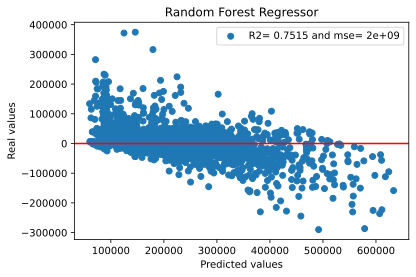

In [33]:
model_test(random_forest_regressor_model,
           'Random Forest Regressor', X_test, y_test)

In [34]:
model_top_deviation(random_forest_regressor_model, X_test, y_test)

Rooms      Square  DistrictId  Social_1  Helthcare_2  Social_2  Shops_1  \
23      1.0   47.347305          23         2            0       475        0   
1918    1.0   46.869541           1         1            0       264        1   
2439    1.0   39.709106           6         5            0      1564        0   
2094    4.0   98.385445          69        33            1      6783        9   
350     3.0  126.621361          24        50            2     12238        3   

      Floor  HouseFloor  LifeSquare  Social_3  Ecology_1  KitchenSquare  \
23        7         9.0   35.936615         0   0.014073            1.0   
1918     16        24.0   35.936615         0   0.007122            1.0   
2439     10        25.0    1.836365         0   0.243205            1.0   
2094     14        22.0   76.081772         3   0.000991            9.0   
350      22        48.0   62.455482         8   0.111627           12.0   

      HouseYear  mean_price_dr  mean_price_by_rooms  large_district  \
23         1977  100961.812500        159850.796875             171   
1918       1977  147454.609375        159850.796875             186   
2439       2017  135294.171875        159850.796875             156   
2094       1979  500774.125000        383251.093750               8   
350        2011  361843.250000        289337.968750              12   

              Price     Price_test             SD  
23    109370.074757  571069.052600  461698.977843  
1918  157661.574956  594565.299770  436903.724814  
2439  132332.172610  556931.539960  424599.367349  
2094  488248.841502   91775.321076  396473.520426  
350   495720.931812  100226.363761  395494.568051

# Результат

In [35]:
def models_r2(models, test, valid):
    scores = pd.DataFrame(columns=['name', 'r2', 'mse'])
    for name, model in models.items():
        test_pred = model.predict(test)
        r2 = r2_score(valid, test_pred)
        mse = mean_squared_error(valid, test_pred)
        scores = scores.append(
            {'name': name, 'r2': r2, 'mse': mse}, ignore_index=True)
    scores.sort_values('r2', ascending=False, inplace=True)
    return scores

In [36]:
models_score_test = models_r2(models_dict, X_test, y_test)
models_score_train = models_r2(models_dict, X_train, y_train)

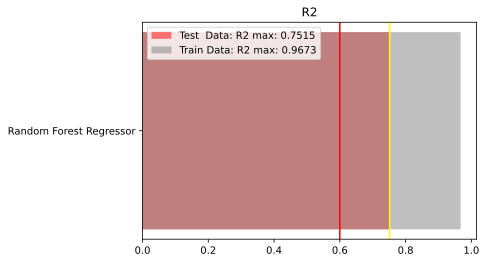

In [37]:
r2_max_test = models_score_test['r2'].max()
r2_max_train = models_score_train['r2'].max()
plt.barh(models_score_test['name'], models_score_test['r2'],
         alpha=0.5, color='red', label=f'Test  Data: R2 max: {r2_max_test:.4f}')
plt.barh(models_score_train['name'], models_score_train['r2'],
         alpha=0.5, color='grey', label=f'Train Data: R2 max: {r2_max_train:.4f}')
plt.title('R2')
plt.legend()
plt.axvline(0.6, color='red')
plt.axvline(r2_max_test, color='yellow')
plt.show()

In [38]:
best_model = models_dict['Random Forest Regressor']

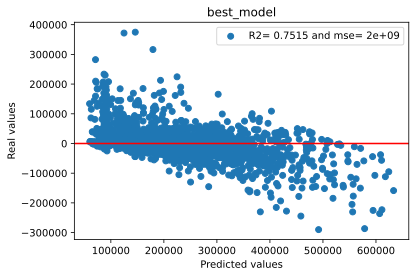

In [39]:
model_test(best_model, 'best_model', X_test, y_test)

# Вывод данных

In [40]:
test = data_prepare(test)

In [41]:
test_features = list(X_train.columns)

In [42]:
test[test_features].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 4999
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Rooms                5000 non-null   float32
 1   Square               5000 non-null   float32
 2   DistrictId           5000 non-null   uint8  
 3   Social_1             5000 non-null   uint8  
 4   Helthcare_2          5000 non-null   uint8  
 5   Social_2             5000 non-null   uint16 
 6   Shops_1              5000 non-null   uint8  
 7   Floor                5000 non-null   uint8  
 8   HouseFloor           5000 non-null   float32
 9   LifeSquare           5000 non-null   float32
 10  Social_3             5000 non-null   uint8  
 11  Ecology_1            5000 non-null   float32
 12  KitchenSquare        5000 non-null   float32
 13  HouseYear            5000 non-null   uint16 
 14  mean_price_dr        5000 non-null   float32
 15  mean_price_by_rooms  5000 non-null   f

In [43]:
test['Price'] = best_model.predict(test[test_features])

mu = 214395.98 and sigma = 79304.63


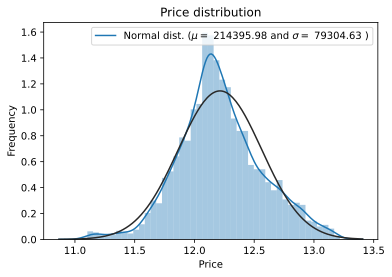

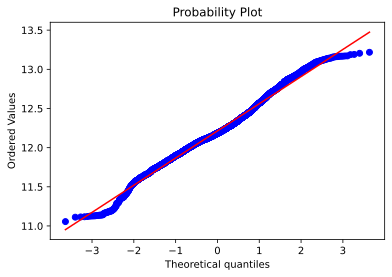

In [44]:
price_log = np.log1p(test['Price'])
sns.distplot(price_log, fit=norm)

mu, sigma = norm.fit(test['Price'])

print(f'mu = {mu:.2f} and sigma = {sigma:.2f}')

plt.legend(
    [f'Normal dist. ($\mu=$ {mu:.2f} and $\sigma=$ {sigma:.2f} )'], loc='best')
plt.ylabel('Frequency')
plt.title('Price distribution')

# QQ-plot
fig = plt.figure()
res = stats.probplot(price_log, plot=plt)
plt.show()

In [45]:
test[['Id', 'Price']].to_csv('OSIvanov_predictions.csv', index=None)